In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import copy
import sys
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import train_test_split
import ipyvolume as ipv


In [2]:
fileroot='2024_03_08_TRF_Maleen/'
filename='2024_03_08_TRF_Maleen_01'

datapath='/home/maleen/rosbags/Transformers/datasets/training/'

# Load the DataFrame from the pickle file
df1 = pd.read_pickle(datapath + filename + '.pkl')

arrays = [np.array(item) for item in df1['Skeleton_3D']]
timestamps = [np.array(item) for item in df1['Skeleton_Timestamp']]

# Convert datetime to seconds from start
timestamps = (timestamps - timestamps[0])

# Stack these arrays along a new axis to create a 3D NumPy array
# Each "slice" of this 3D array represents one frame of keypoints
skeleton_3d_frames = np.stack(arrays, axis=0)

In [3]:
#Create masks for the data (1 = data present, 0 = data missing)
# Correcting the mask values
masks = np.where(np.isnan(skeleton_3d_frames).any(axis=2), 0, 1)  # 0 for missing, 1 for present

In [4]:
# Calculate the differences in position and time
position_diff = np.diff(skeleton_3d_frames, axis=0)
time_diff = np.diff(timestamps)

# Ensure that time_diff is of shape (n,1,1) so that it broadcasts correctly when dividing
time_diff = time_diff[:, np.newaxis, np.newaxis]

# Update masks to match the dimensions of position_diff and time_diff
# We use the bitwise AND operator to ensure that both the current and previous frames are valid
masks_pos = masks[:-1, :] & masks[1:, :]

# Add an additional dimension to masks
masks_pos = masks_pos[:,:,np.newaxis]

# Now we calculate velocity, handling missing data according to the mask
# Where the mask is False, we will get np.nan
skel_vel = np.where(masks_pos, position_diff / time_diff, np.nan)

masks_velocity = masks_pos[:-1, :] & masks_pos[1:, :]

# Calculate the differences in velocity
velocity_diff = np.diff(skel_vel, axis=0)

# Now we calculate acceleration, handling missing data according to the mask
# Where the mask is False, we will get np.nan
skel_acc = np.where(masks_velocity, velocity_diff / time_diff[:-1, :, :], np.nan)  # Use time_diff with one less time dimension

In [5]:
# Now, slice skeleton_3d_frames and skel_vel to match the dimensions of skell_acc
skel_pos= skeleton_3d_frames[2:]
skel_vel = skel_vel[1:]
masks = masks[2:]

In [6]:
masks.shape

(1018, 18)

In [7]:
# Initialize arrays to hold the normalized data, medians, and IQRs
norm_pos = np.empty_like(skel_pos)
medians_per_joint_axis_skel_pos = np.empty((skel_pos.shape[1], skel_pos.shape[2]))
iqrs_per_joint_axis_skel_pos = np.empty((skel_pos.shape[1], skel_pos.shape[2]))

norm_vel= np.empty_like(skel_vel)
medians_per_joint_axis_vel = np.empty((skel_vel.shape[1], skel_vel.shape[2]))
iqrs_per_joint_axis_vel = np.empty((skel_vel.shape[1], skel_vel.shape[2]))

norm_acc = np.empty_like(skel_acc)
medians_per_joint_axis_acc = np.empty((skel_acc.shape[1], skel_acc.shape[2]))
iqrs_per_joint_axis_acc = np.empty((skel_acc.shape[1], skel_acc.shape[2]))

def robust_normalize_data_with_clipping(data, masks, medians_per_joint_axis, iqrs_per_joint_axis, normalized_data, clipping_percentiles=(1, 99)):
    for joint in range(data.shape[1]):  # For each joint
        for axis in range(data.shape[2]):  # For each axis (x, y, z)
            joint_axis_data = data[:, joint, axis]
            mask_for_joint = masks[:, joint]

            # Select valid data based on the mask
            valid_data = joint_axis_data[mask_for_joint == 1]

            # Determine clipping thresholds based on percentiles
            lower_threshold, upper_threshold = np.percentile(valid_data, clipping_percentiles) if valid_data.size > 0 else (np.nan, np.nan)

            # Clip the data based on valid mask and thresholds
            clipped_values = np.clip(joint_axis_data, lower_threshold, upper_threshold)

            # Calculate median and IQR for clipped data
            median = np.median(clipped_values[mask_for_joint == 1]) if np.any(mask_for_joint == 1) else np.nan
            q75, q25 = np.percentile(clipped_values[mask_for_joint == 1], [75 ,25]) if np.any(mask_for_joint == 1) else (np.nan, np.nan)
            iqr = q75 - q25

            # Store the calculated medians and IQRs
            medians_per_joint_axis[joint, axis] = median
            iqrs_per_joint_axis[joint, axis] = iqr

            # Normalize the clipped data, avoiding division by zero
            if iqr > 0:
                normalized_values = (clipped_values - median) / iqr
            else:
                normalized_values = clipped_values  # Keep original values if IQR is 0 or nan

            # Apply normalization only where data is present
            normalized_data[:, joint, axis] = np.where(mask_for_joint == 1, normalized_values, np.nan)
            
    return normalized_data, medians_per_joint_axis, iqrs_per_joint_axis

# Example usage with your data
# Note: masks, skel_pos, skel_vel, skel_acc should be defined in your context

norm_pos, medians_pos, iqrs_pos = robust_normalize_data_with_clipping(skel_pos, masks, medians_per_joint_axis_skel_pos, iqrs_per_joint_axis_skel_pos, norm_pos)
norm_vel, medians_vel, iqrs_vel = robust_normalize_data_with_clipping(skel_vel, masks, medians_per_joint_axis_vel, iqrs_per_joint_axis_vel, norm_vel)
norm_acc, medians_acc, iqrs_acc = robust_normalize_data_with_clipping(skel_acc, masks, medians_per_joint_axis_acc, iqrs_per_joint_axis_acc, norm_acc)


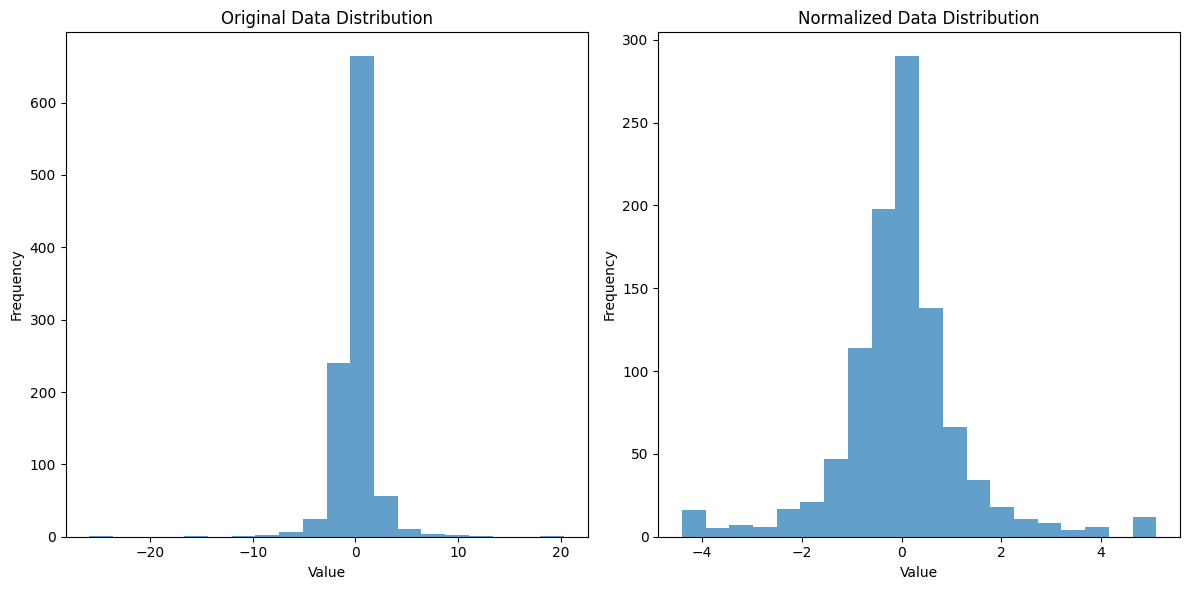

Median of normalized data: -1.4094628242311558e-18
Data points within [-1, 1] (IQR): 925 out of 1018
Data points within [-1, 1] (IQR): 688 out of 1018


In [8]:
data=skel_acc
norm_data=norm_acc
# Plot the original and normalized data for a specific joint and axis
joint, axis = 0, 0  # Change as needed
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(data[:, joint, axis], bins=20, alpha=0.7, label='Original')
plt.title("Original Data Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(norm_data[:, joint, axis], bins=20, alpha=0.7, label='Normalized')
plt.title("Normalized Data Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Check the median and range of the normalized data
normalized_median = np.nanmedian(norm_data[:, joint, axis])
print("Median of normalized data:", normalized_median)

within_iqr = ((norm_data[:, joint, axis] > -2) & (norm_data[:, joint, axis] < 2)).sum()
print(f"Data points within [-1, 1] (IQR): {within_iqr} out of {norm_data.shape[0]}")

within_iqr2 = ((data[:, joint, axis] > -1) & (data[:, joint, axis] < 1)).sum()
print(f"Data points within [-1, 1] (IQR): {within_iqr2} out of {norm_data.shape[0]}")

In [9]:
class SkeletalInputEmbedding(nn.Module):
    def __init__(self, num_joints=18, dof=3, embed_dim=128, device='gpu'):
        super().__init__()
        self.num_joints = num_joints
        self.dof = dof
        self.embed_dim = embed_dim
        self.device = device  # Store the device

        self.joint_embed = nn.Linear(dof, embed_dim)
        # self.vel_embed = nn.Linear(dof, embed_dim)
        # self.acc_embed = nn.Linear(dof, embed_dim)

    #def forward(self, joint_positions, velocities, accelerations, mask=None):
    def forward(self, joint_positions, mask=None):
        # Replace NaNs in the input data
        joint_positions = torch.nan_to_num(joint_positions)
        # velocities = torch.nan_to_num(velocities)
        # accelerations = torch.nan_to_num(accelerations)


        # Embedding and combining the embeddings
        joint_embeddings = self.joint_embed(joint_positions)
        # vel_embeddings = self.vel_embed(velocities)
        # acc_embeddings = self.acc_embed(accelerations)
        combined_embeddings = joint_embeddings #+ vel_embeddings + acc_embeddings

        # Apply mask after NaN replacement
        if mask is not None:
            mask = mask.unsqueeze(-1)  # Add a dimension for the features
            combined_embeddings = combined_embeddings * mask

        # Calculate positional encoding dynamically
        seq_len = joint_positions.size(1)  # Assuming joint_positions is [seq_len, num_joints, dof]
        positional_encoding = self.get_sinusoidal_encoding(seq_len * self.num_joints, self.embed_dim)
        # print("Device of input embeddings:", combined_embeddings.device)
        # print("Device of positional encodings:", positional_encoding.device)

        positional_encoding = positional_encoding.view(seq_len, self.num_joints, self.embed_dim)

        combined_embeddings += positional_encoding.unsqueeze(0)  # Unsqueeze to add batch dimension for broadcasting
        combined_embeddings = combined_embeddings.view(-1, seq_len, self.num_joints, self.embed_dim)

        return combined_embeddings

    def get_sinusoidal_encoding(self, total_len, embed_dim):
        # Make sure the position tensor is created on the right device
        position = torch.arange(0, total_len, dtype=torch.float, device=self.device).unsqueeze(1)
    
        # Calculate the division term for sinusoidal encoding
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(np.log(10000.0) / embed_dim)).to(self.device)
        div_term = div_term.unsqueeze(0)  # Reshape for broadcasting
    
        # Create the positional encoding matrix
        pe = torch.zeros(total_len, embed_dim, device=self.device)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
    
        return pe



In [10]:

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, dropout_rate=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        
        # Transformer Encoder Layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.embed_dim,
            nhead=self.num_heads,
            dropout=self.dropout_rate,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=self.num_layers)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        """
        src: Tensor of shape (batch_size, seq_len, num_joints, embed_dim)
        src_mask: None or Tensor for masking in multi-head attention (not used in this example)
        src_key_padding_mask: Tensor of shape (batch_size, seq_len * num_joints) indicating which elements are padded
        """
        # Reshaping src to fit the transformer's input requirement
        
        batch_size, seq_len, num_joints, embed_dim = src.size()
        src = src.view(batch_size, seq_len * num_joints, embed_dim)  # Flatten seq_len and num_joints

        #print("SRC shape:", src.shape)

        # Applying Transformer Encoder
        output = self.transformer_encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        
        # Reshape back to (batch_size, seq_len, num_joints, embed_dim)
        output = output.view(batch_size, seq_len, num_joints, embed_dim)
        return output


In [11]:
class TransformerDecoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, num_joints, dropout_rate=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.num_joints = num_joints

        # Transformer Decoder Layer
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=self.embed_dim,
            nhead=self.num_heads,
            dropout=self.dropout_rate,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=self.num_layers)

        # Output layer to convert decoder output to joint position dimension
        self.output_layer = nn.Linear(self.embed_dim, 3)  # Assuming output per joint is a 3D position

    # @staticmethod
    # def generate_square_subsequent_mask(sz):
    #     mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    #     mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    #     return mask

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        """
        tgt: Tensor of shape (batch_size, output_seq_len, num_joints, embed_dim), initially could be start token or zero vectors
        memory: Tensor of shape (batch_size, input_seq_len * num_joints, embed_dim), output from the Transformer encoder
        tgt_mask: Mask to ensure the decoder's predictions are based only on past positions
        memory_mask: Optional, to mask encoder outputs if necessary
        tgt_key_padding_mask: Tensor of shape (batch_size, output_seq_len * num_joints) for masking target sequences
        memory_key_padding_mask: Tensor of shape (batch_size, input_seq_len * num_joints) for masking memory sequences
        """
        # Reshaping memory and target to fit the transformer's input requirement
        batch_size, input_seq_len, num_joints, embed_dim = memory.size()
        batch_size, output_seq_len, num_joints, embed_dim = tgt.size()
        memory = memory.view(batch_size, input_seq_len * num_joints, embed_dim)  # Ensure memory is correctly reshaped
        tgt = tgt.view(batch_size, output_seq_len * num_joints, embed_dim)  # Flatten output_seq_len and num_joints

        # Transformer Decoder
        output = self.transformer_decoder(
            tgt, memory, tgt_mask=tgt_mask, memory_mask=memory_mask,
            tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask
        )

        # Reshape back and project to joint position dimensions
        output = output.view(batch_size, output_seq_len, num_joints, embed_dim)
        output = self.output_layer(output)

        return output


In [12]:
def generate_sequences(norm_pos, norm_vel, norm_acc, mask, input_length=60, predict_length=60):
    num_frames = norm_pos.shape[0]
    num_joints = norm_pos.shape[1]

    # Calculate the total number of sequences we can create
    num_sequences = num_frames - input_length - predict_length + 1

    # Initialize arrays to store the input and target sequences
    X_pos = np.zeros((num_sequences, input_length, num_joints, 3))
    X_vel = np.zeros((num_sequences, input_length, num_joints, 3))
    X_acc = np.zeros((num_sequences, input_length, num_joints, 3))
    Y_pos = np.zeros((num_sequences, predict_length, num_joints, 3))
    Y_vel = np.zeros((num_sequences, predict_length, num_joints, 3))
    Y_acc = np.zeros((num_sequences, predict_length, num_joints, 3))
    X_mask = np.zeros((num_sequences, input_length, num_joints))
    Y_mask = np.zeros((num_sequences, predict_length, num_joints))

    # Create sequences
    for i in range(num_sequences):
        X_pos[i] = norm_pos[i:i + input_length]
        X_vel[i] = norm_vel[i:i + input_length]
        X_acc[i] = norm_acc[i:i + input_length]
        Y_pos[i] = norm_pos[i + input_length:i + input_length + predict_length]
        Y_vel[i] = norm_vel[i + input_length:i + input_length + predict_length]
        Y_acc[i] = norm_acc[i + input_length:i + input_length + predict_length]
        X_mask[i] = mask[i:i + input_length]
        Y_mask[i] = mask[i + input_length:i + input_length + predict_length]

    return X_pos, X_vel, X_acc, X_mask, Y_pos, Y_vel, Y_acc, Y_mask


def create_shifted_mask(seq_length, num_joints):
    # seq_length is the number of time steps
    # num_joints is the number of joints per time step
    total_length = seq_length * num_joints
    mask = torch.ones((total_length, total_length), dtype=torch.float32) * float('-inf')  # Start with everything masked
    for i in range(seq_length):
        for j in range(i + 1):  # Allow visibility up to and including the current time step
            start_row = i * num_joints
            end_row = start_row + num_joints
            start_col = j * num_joints
            end_col = start_col + num_joints
            mask[start_row:end_row, start_col:end_col] = 0.0  # Unmask the allowed region

    return mask

class MaskedMSELoss(nn.Module):
    def __init__(self):
        super(MaskedMSELoss, self).__init__()

    def forward(self, output, target, output_mask, target_mask):
        # Ensure that the masks are applied, and only the relevant positions are used in loss calculation
        masked_output = output * output_mask
        masked_target = target * target_mask

        # Compute the squared differences
        squared_diff = (masked_output - masked_target) ** 2

        # Apply masks to the squared differences
        # This step is technically not necessary if the masks for output and target are the same
        masked_squared_diff = squared_diff * output_mask * target_mask

        # Calculate the mean of the squared differences while avoiding division by zero
        # This only considers the number of elements that are included in the mask
        loss = masked_squared_diff.sum() / (output_mask * target_mask).sum().clamp(min=1)

        return loss

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the saved model weights
checkpoint = torch.load('/home/maleen/transformer_models/best_model.pth', map_location=device)
embed_dim = 128
num_heads = 8
num_layers = 6
num_joints = 18
dropout_rate = 0.1
input_length = 20
predict_length = 10
autoregressiveloops=10
batch_size = 1

# Initialize the models with the same configuration as during training
embedding = SkeletalInputEmbedding(num_joints=num_joints, dof=3, embed_dim=embed_dim,device=device).to(device)
encoder = TransformerEncoder(embed_dim, num_heads, num_layers, dropout_rate).to(device)
decoder = TransformerDecoder(embed_dim, num_heads, num_layers, num_joints, dropout_rate).to(device)

# Load state dicts
embedding.load_state_dict(checkpoint['embedding_state_dict'])
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])

X_pos, X_vel, X_acc, X_mask, Y_pos, Y_vel, Y_acc, Y_mask = generate_sequences(norm_pos, norm_vel, norm_acc, masks, input_length, predict_length)

# Convert to PyTorch tensors
X_pos_tensor = torch.tensor(X_pos, dtype=torch.float32)
X_vel_tensor = torch.tensor(X_vel, dtype=torch.float32)
X_acc_tensor = torch.tensor(X_acc, dtype=torch.float32)
X_mask_tensor = torch.tensor(X_mask, dtype=torch.bool)

Y_pos_tensor = torch.tensor(Y_pos, dtype=torch.float32)
Y_vel_tensor = torch.tensor(Y_vel, dtype=torch.float32)
Y_acc_tensor = torch.tensor(Y_acc, dtype=torch.float32)
Y_mask_tensor = torch.tensor(Y_mask, dtype=torch.bool)

# Create the DataLoader for inference data
dataset = TensorDataset(X_pos_tensor, X_vel_tensor, X_acc_tensor, X_mask_tensor, Y_pos_tensor, Y_mask_tensor)
inference_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Prepare for autoregressive decoding
predicted_positions = []

criterion = MaskedMSELoss()

# Perform inference across all batches
for batch in inference_loader:
    X_pos_batch, X_vel_batch, X_acc_batch, X_mask_batch, Y_pos_batch, Y_mask_batch = [b.to(device) for b in batch]

    # Encoder pass
    src_key_padding_mask = ~X_mask_batch.view(batch_size, input_length * num_joints)
    input_embeddings = embedding(X_pos_batch, X_mask_batch)
    memory = encoder(input_embeddings, src_key_padding_mask=src_key_padding_mask)

    
    # Initialize the start token for decoding
    current_pos = X_pos_batch[:, -1:, :, :]
    current_mask = X_mask_batch[:,-1:,:]

    for i in range(autoregressiveloops):
        # Embed the current position
        Y_expected= Y_pos_batch[:,i:i+1,:,:]
        Y_mask_expected = Y_mask_batch[:,i:i+1,:]
        
        current_embeddings = embedding(current_pos, current_mask)
        # Decoder pass
        output = decoder(current_embeddings, memory, tgt_key_padding_mask=None, memory_key_padding_mask=src_key_padding_mask)
    
        # Update current_pos for the next prediction
        current_pos = output[:, :, :, :].detach()  # only take the last timestep
    
        predicted_positions.append(current_pos.squeeze().cpu().numpy())
    
        Xmask_expanded = current_mask.unsqueeze(-1).expand_as(output)
        Xmask_expanded = Xmask_expanded.where(~torch.isnan(output), torch.zeros_like(Xmask_expanded))
        output = output.where(~torch.isnan(output), torch.zeros_like(output))
        # masked_output = output * Xmask
    
        Ymask_expanded = Y_mask_expected.unsqueeze(-1).expand_as(Y_expected)
        Ymask_expanded = Ymask_expanded.where(~torch.isnan(Y_expected), torch.zeros_like(Ymask_expanded))
        Y_expected = Y_expected.where(~torch.isnan(Y_pos_batch), torch.zeros_like(Y_expected))
        # masked_y_pos = Y_pos_batch * Ymask
    
        # Compute loss
        
        loss = criterion(output, Y_expected, Xmask_expanded, Ymask_expanded)

        print(loss)

    
# Convert the list of predicted positions to a more manageable form, e.g., a NumPy array
predicted_positions = np.array(predicted_positions)

print("Predicted Positions:", predicted_positions)


tensor(0.4775, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1112, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.7385, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.3276, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.9943, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.1422, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.1916, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.9907, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.9075, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.2640, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4382, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2138, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.8284, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.7885, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.0688, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.2777, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.2465, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.2154, device='cuda:0', grad_fn=<DivBack

In [ ]:
def reverse_normalization(normalized_data, medians_per_joint_axis, iqrs_per_joint_axis, masks):
    original_data = np.empty_like(normalized_data)  # Initialize an array to hold the original data

    # Iterate over each joint and each axis
    for joint in range(normalized_data.shape[0]):
        for axis in range(normalized_data.shape[1]):
            # Retrieve the median and IQR for this joint and axis
            median = medians_per_joint_axis[joint, axis]
            iqr = iqrs_per_joint_axis[joint, axis]

            # Retrieve the normalized values for this joint and axis
            normalized_values = normalized_data[ joint, axis]

            # Calculate the original values based on the normalization formula
            original_values = (normalized_values * iqr) + median

            # Apply the mask to restore original data only where it was initially present
            mask_for_joint = masks[:, joint]
            original_data[ joint, axis] = np.where(mask_for_joint == 1, original_values, np.nan)

    return original_data


In [ ]:
# Assuming `skeleton_3d_data[500]` is your input data

mask=np.array(X_mask_batch[0][0].cpu())
mask_expanded = np.tile(mask[:, np.newaxis], (1, predicted_positions[0].shape[1]))

mask_ones = np.ones((1, 18))

reversed_data = reverse_normalization(predicted_positions[0], medians_pos, iqrs_pos, mask_ones)

masked_reversed_data = np.where(mask_expanded, reversed_data, np.nan)

data = masked_reversed_data

# Filter out the NaN values from the first 18 keypoints
valid_keypoints = ~np.isnan(data[:18, :]).any(axis=1)  # Corrected version
filtered_data = data[:18][valid_keypoints]


# Define connections based on your body model
original_connections = [
    (16, 14),(14, 0),                #Right Head
    (17, 15),(15, 0),                #Left Head
    (0, 1),                          #Neck
    (1, 2), (2, 3), (3, 4),          # Right arm
    (1, 5), (5, 6), (6, 7),          # Left arm
    (1, 8), (8, 9), (9, 10),         # Right leg
    (1, 11), (11, 12), (12, 13),     # Left leg
    (8, 11)                          # Between hips
]

# Create a mapping from old indices to new indices after NaN removal
index_mapping = {old_index: new_index for new_index, old_index in enumerate(np.where(valid_keypoints)[0])}

# Create a new list of connections that only includes the valid keypoints
new_connections = [(index_mapping[start], index_mapping[end])
                   for start, end in original_connections
                   if start in index_mapping and end in index_mapping]

# Create the 3D scatter plot
ipv.figure()
scatter = ipv.scatter(filtered_data[:, 0], filtered_data[:, 1], filtered_data[:, 2], marker='sphere', size=2)

# Draw lines for the new skeletal links
for start, end in new_connections:
    ipv.plot(filtered_data[[start, end], 0], filtered_data[[start, end], 1], filtered_data[[start, end], 2], color='red')

# Show the plot
ipv.view(azimuth=0, elevation=-90)
ipv.show()

In [ ]:
original_connections = [
    (16, 14), (14, 0),               # Right Head
    (17, 15), (15, 0),               # Left Head
    (0, 1),                          # Neck
    (1, 2), (2, 3), (3, 4),          # Right arm
    (1, 5), (5, 6), (6, 7),          # Left arm
    (1, 8), (8, 9), (9, 10),         # Right leg
    (1, 11), (11, 12), (12, 13),     # Left leg
    (8, 11)                          # Between hips
]


# First dataset processing (already provided code)
mask = np.array(X_mask_batch[0][0].cpu())
mask_expanded = np.tile(mask[:, np.newaxis], (1, predicted_positions[0].shape[1]))
mask_ones = np.ones((1, 18))
reversed_data = reverse_normalization(predicted_positions[0], medians_pos, iqrs_pos, mask_ones)
masked_reversed_data = np.where(mask_expanded, reversed_data, np.nan)
data = masked_reversed_data
valid_keypoints = ~np.isnan(data[:18, :]).any(axis=1)
filtered_data = data[:18][valid_keypoints]

# Create mapping from old indices to new indices after NaN removal
index_mapping = {old_index: new_index for new_index, old_index in enumerate(np.where(valid_keypoints)[0])}
# Create new connections for the first dataset
new_connections = [(index_mapping[start], index_mapping[end])
                   for start, end in original_connections
                   if start in index_mapping and end in index_mapping]

# Second dataset processing
mask_y = X_mask[0][0] # Assuming you need a similar mask or adjust accordingly
mask_expanded_y = np.tile(mask_y[:, np.newaxis], (1, Y_pos[0][0].shape[1]))
reversed_data_y = reverse_normalization(Y_pos[0][0], medians_pos, iqrs_pos, mask_ones)
masked_reversed_data_y = np.where(mask_expanded_y, reversed_data_y, np.nan)
data_y = masked_reversed_data_y
valid_keypoints_y = ~np.isnan(data_y[:18, :]).any(axis=1)
filtered_data_y = data_y[:18][valid_keypoints_y]

# Create mapping from old indices to new indices for the second dataset
index_mapping_y = {old_index: new_index for new_index, old_index in enumerate(np.where(valid_keypoints_y)[0])}
# Create new connections for the second dataset
new_connections_y = [(index_mapping_y[start], index_mapping_y[end])
                     for start, end in original_connections
                     if start in index_mapping_y and end in index_mapping_y]

# Plot configuration
ipv.figure()

# Plot first dataset
scatter = ipv.scatter(filtered_data[:, 0], filtered_data[:, 1], filtered_data[:, 2], color='blue', marker='sphere', size=2)
for start, end in new_connections:
    ipv.plot(filtered_data[[start, end], 0], filtered_data[[start, end], 1], filtered_data[[start, end], 2], color='red')

# Plot second dataset
scatter_y = ipv.scatter(filtered_data_y[:, 0], filtered_data_y[:, 1], filtered_data_y[:, 2], color='green', marker='sphere', size=2)
for start, end in new_connections_y:
    ipv.plot(filtered_data_y[[start, end], 0], filtered_data_y[[start, end], 1], filtered_data_y[[start, end], 2], color='lime')

ipv.view(azimuth=0, elevation=-90)
ipv.show()


In [ ]:
predicted_positions[6]

In [ ]:
mask